#Disclaimer Dataset hanya sampai tahun 2020

# Libraries Used

In [16]:
# Install libraries
!pip install fasttext
!pip install sastrawi
!pip install emoji
!pip install langdetect

In [17]:
# import libraries
import sklearn # Our library for TF-IDF, SVM, and Random forest
import fasttext # Our library for fasttext model
import nltk
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, RocCurveDisplay, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
import fasttext
import os
from string import punctuation
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from langdetect import detect
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() # setting seaborn default for plots
import emoji
from imblearn.combine import SMOTETomek
import joblib

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Exploratory Data Analysis

In [18]:
df = pd.read_csv('/content/data.csv')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4231 entries, 0 to 4230
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                4231 non-null   int64 
 1   label             4231 non-null   int64 
 2   tanggal           4231 non-null   object
 3   judul             4231 non-null   object
 4   narasi            4231 non-null   object
 5   nama file gambar  4231 non-null   object
dtypes: int64(2), object(4)
memory usage: 198.5+ KB


In [20]:
df.head()

,ID,label,tanggal,judul,narasi,nama file gambar
0,71,1,17-Aug-20,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,71.jpg
1,461,1,17-Jul-20,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,461.png
2,495,1,13-Jul-20,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,495.png
3,550,1,8-Jul-20,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",550.png
4,681,1,24-Jun-20,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,681.jpg


In [21]:
df.shape

(4231, 6)

In [22]:
df.describe(include=['O'])

,tanggal,judul,narasi,nama file gambar
count,4231,4231,4231,4231
unique,1339,4219,4209,4231
top,16-Mar-20,Foto Sekarang malesiya sapu habis penduduk asi...,Cek tangkapan layar.,71.jpg
freq,18,2,5,1


In [23]:
panjang_judul_rata_rata = df['judul'].apply(lambda x: len(x.split())).mean()
round(panjang_judul_rata_rata, 1)

9.0

In [24]:
panjang_narasi_rata_rata = df['narasi'].apply(lambda x: len(x.split())).mean()
round(panjang_narasi_rata_rata, 1)

26.0

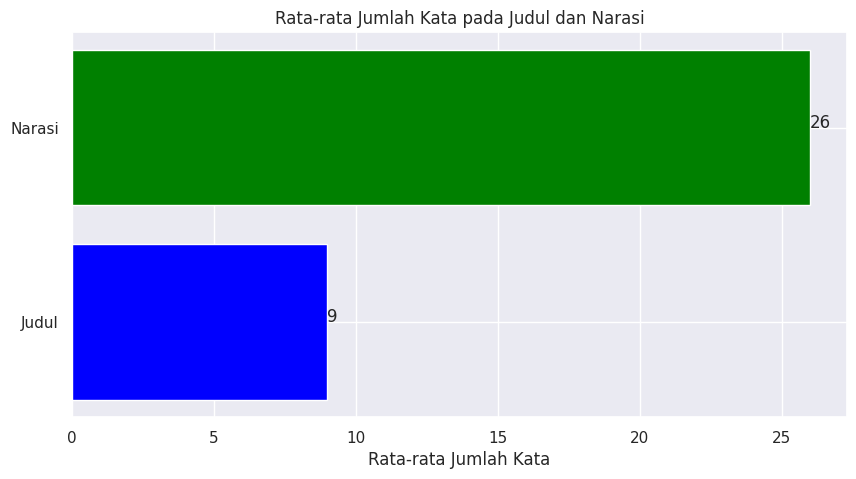

In [25]:
# Plot the average word counts
avg_word_counts = [round(panjang_judul_rata_rata), round(panjang_narasi_rata_rata)]
categories = ['Judul', 'Narasi']

plt.figure(figsize=(10, 5))
plt.barh(categories, avg_word_counts, color=['blue', 'green'])
plt.xlabel('Rata-rata Jumlah Kata')
plt.title('Rata-rata Jumlah Kata pada Judul dan Narasi')
for index, value in enumerate(avg_word_counts):
    plt.text(value, index, str(value))
plt.show()

In [26]:
tahun_tahun = df['tanggal'].str[-2:].value_counts().sort_index()
years = tahun_tahun.index.tolist()  # a list of years
counts = tahun_tahun.values  # a corresponding list of counts
print(f"{years} : {counts}")

['15', '16', '17', '18', '19', '20'] : [  47  260  606 1069 1018 1231]


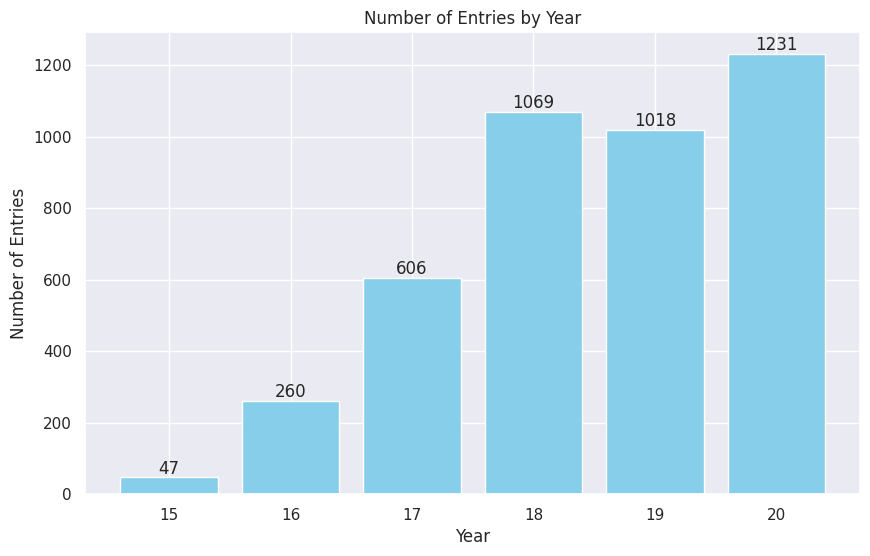

In [27]:
sorted_indices = sorted(range(len(years)), key=lambda k: years[k])
years = [years[i] for i in sorted_indices]
counts = [counts[i] for i in sorted_indices]

# Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(years, counts, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Entries')
plt.title('Number of Entries by Year')

# Add text labels on the bars
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

In [28]:
jumlah_modus_tahun = tahun_tahun.mode()
jumlah_median_tahun = tahun_tahun.median()
modus_tahun = tahun_tahun[tahun_tahun==jumlah_modus_tahun.iloc[-1]]
median_tahun = abs(tahun_tahun-jumlah_median_tahun).idxmin()
print(f"Modus tahun keluar: {modus_tahun.index[0]}")
print(f"Median tahun keluar: {int(median_tahun)}")

Modus tahun keluar: 20
Median tahun keluar: 17


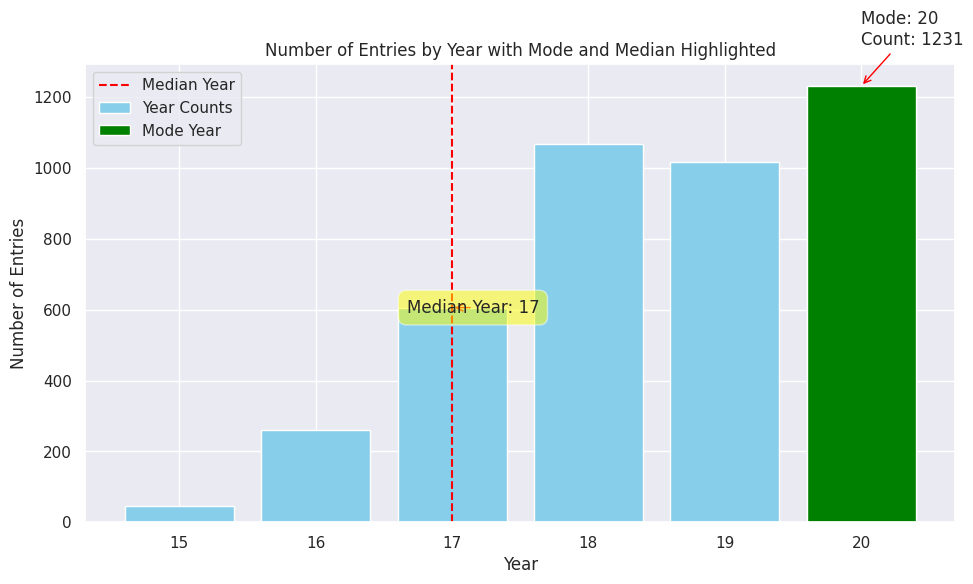

In [29]:
tahun_tahun_sorted = tahun_tahun.sort_index()
years = tahun_tahun_sorted.index
counts = tahun_tahun_sorted.values

# Calculated mode and median year
modus_tahun = modus_tahun.index[0]
median_tahun = abs(tahun_tahun-jumlah_median_tahun).idxmin()

# Count for the mode year for plotting
mode_count = tahun_tahun_sorted[modus_tahun]

# Find the position of the median year to plot a vertical line
median_count = tahun_tahun_sorted[median_tahun]

# Plotting
plt.figure(figsize=(10, 6))

# Plot the bar chart for years
plt.bar(years, counts, color='skyblue', label='Year Counts')

# Highlight the mode year
plt.bar(modus_tahun, mode_count, color='green', label='Mode Year')

# Annotate the mode year
plt.annotate(f'Mode: {modus_tahun}\nCount: {mode_count}',
             xy=(modus_tahun, mode_count),
             xytext=(0, 30),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='red'))

# If the median year is a specific year, plot a vertical line and annotate
median_year_index = list(years).index(median_tahun)
plt.axvline(x=median_year_index, color='red', linestyle='--', label='Median Year')

# Annotate the median year line
plt.annotate(f'Median Year: {median_tahun}',
             xy=(median_year_index, median_count),
             xytext=(15, 0),
             textcoords='offset points',
             ha='center', va='center',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', color='red'))

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Number of Entries')
plt.title('Number of Entries by Year with Mode and Median Highlighted')
plt.legend()

plt.tight_layout()
plt.show()

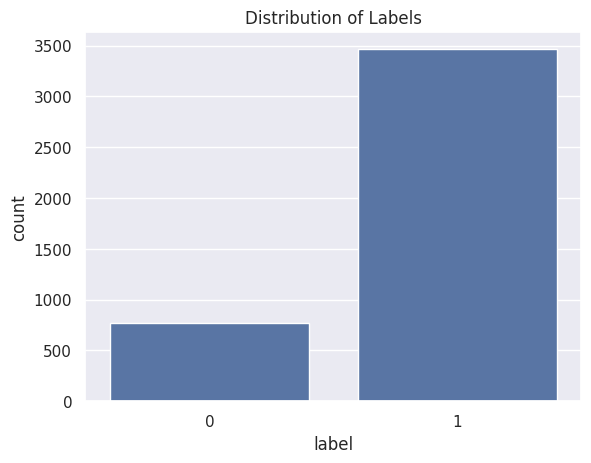

In [30]:
sns.countplot(x='label', data=df)
plt.title('Distribution of Labels')
plt.show()

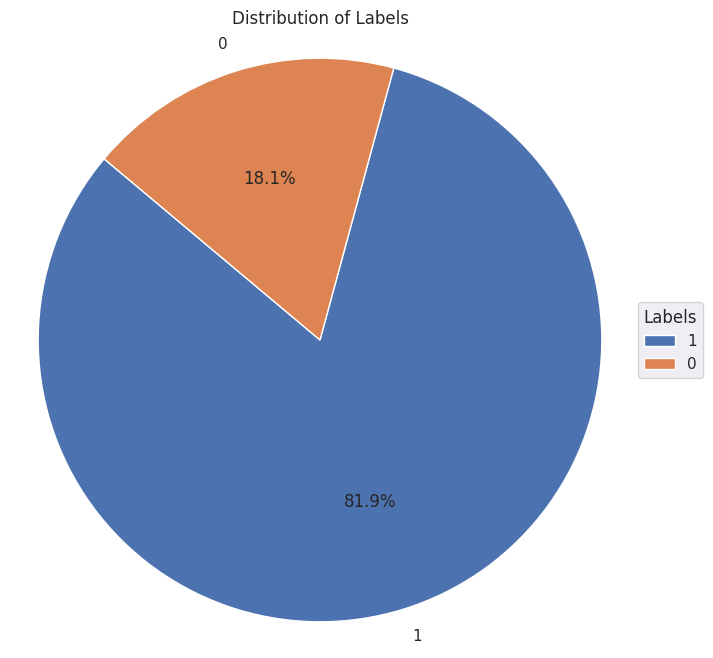

In [31]:
# Get the counts of each label
label_counts = df['label'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Labels')
plt.axis('equal')

plt.legend(label_counts.index, title="Labels", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

In [32]:
# Imabalanced ratio
print(f"Imabalanced Ratio: {label_counts.max()/label_counts.min()}")

Imabalanced Ratio: 4.523498694516971


In [33]:
#Finding the trend over time
bulan_mapping = {
    'Jan': 'Jan', 'Feb': 'Feb', 'Mar': 'Mar', 'Apr': 'Apr', 'Mei': 'May', 'Jun': 'Jun',
    'Jul': 'Jul', 'Agu': 'Aug', 'Sep': 'Sep', 'Okt': 'Oct', 'Nov': 'Nov', 'Des': 'Dec'
}

for bulan_ind, bulan_eng in bulan_mapping.items():
    df['tanggal'] = df['tanggal'].str.replace(bulan_ind, bulan_eng, regex=True)

df['tanggal'] = pd.to_datetime(df['tanggal'], format='%d-%b-%y')

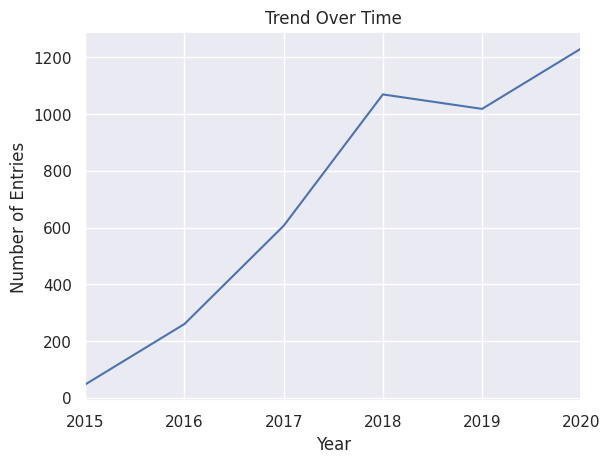

In [34]:
#Resampling by Year
df.set_index('tanggal', inplace=True)
df.resample('Y').size().plot()
plt.title('Trend Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Entries')
plt.show()

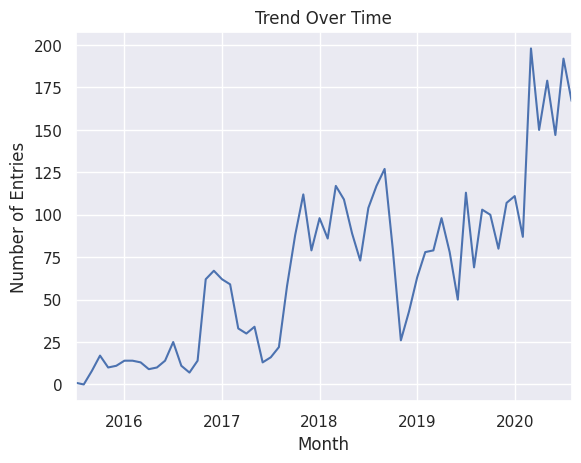

In [35]:
#Resampling by Month
df.resample('M').size().plot()
plt.title('Trend Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Entries')
plt.show()

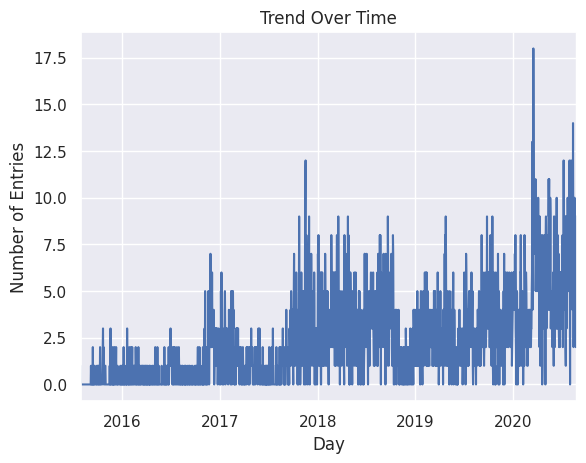

In [36]:
#Resampling by Day
df.resample('D').size().plot()
plt.title('Trend Over Time')
plt.xlabel('Day')
plt.ylabel('Number of Entries')
plt.show()

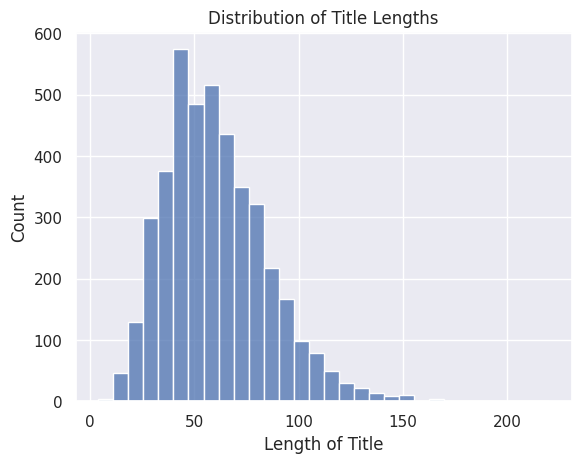

In [37]:
df['judul_length'] = df['judul'].apply(len)
sns.histplot(df['judul_length'], bins=30)
plt.title('Distribution of Title Lengths')
plt.xlabel('Length of Title')
plt.show()

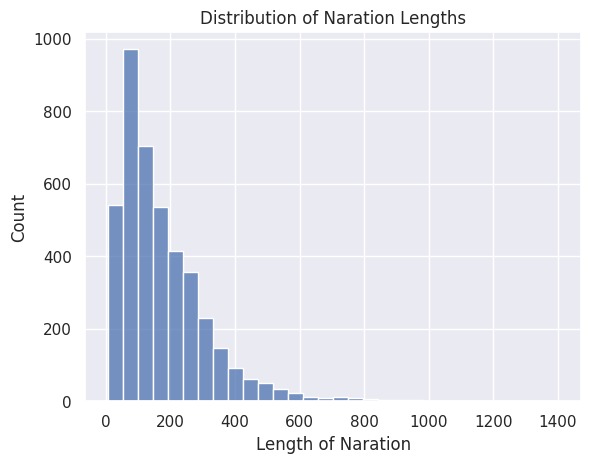

In [38]:
df['narasi_length'] = df['narasi'].apply(len)
sns.histplot(df['narasi_length'], bins=30)
plt.title('Distribution of Naration Lengths')
plt.xlabel('Length of Naration')
plt.show()

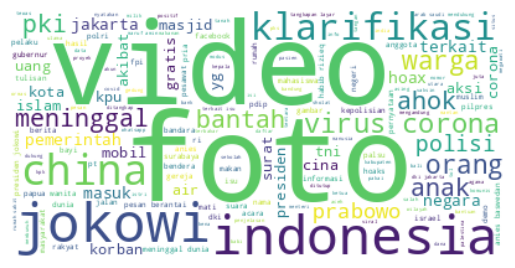

In [39]:
stop_words = set(stopwords.words('indonesian'))

# Combine semua 'judul' text menjadi satu string dan remove stopwords
text = " ".join(judul for judul in df['judul'].dropna())
text_words = text.lower().split()
filtered_text = " ".join(word for word in text_words if word not in stop_words and word.isalpha())

# Generate the word cloud using the filtered text
wordcloud = WordCloud(background_color="white").generate(filtered_text)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

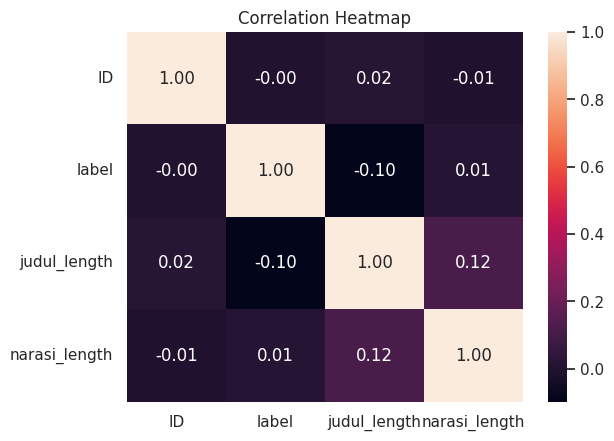

In [40]:
#numerical columns
numerical_df = df.select_dtypes(include=['int64', 'float64'])

sns.heatmap(numerical_df.corr(), annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

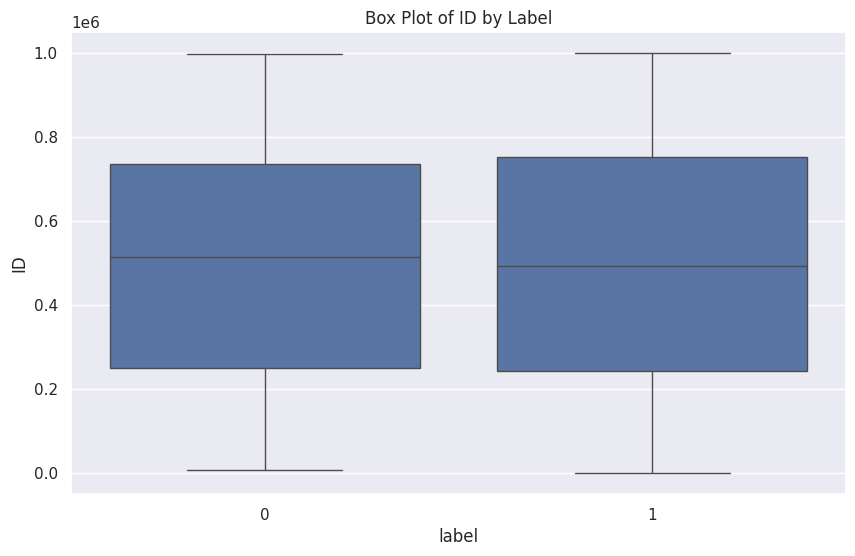

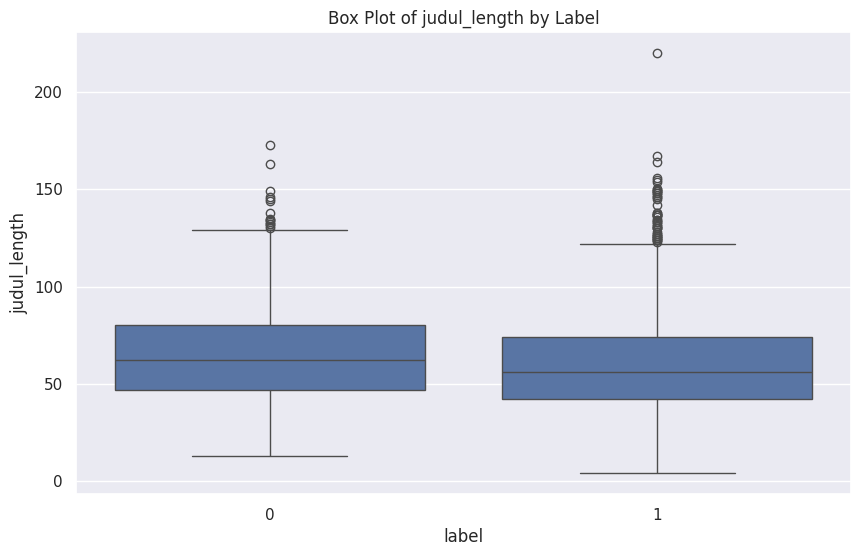

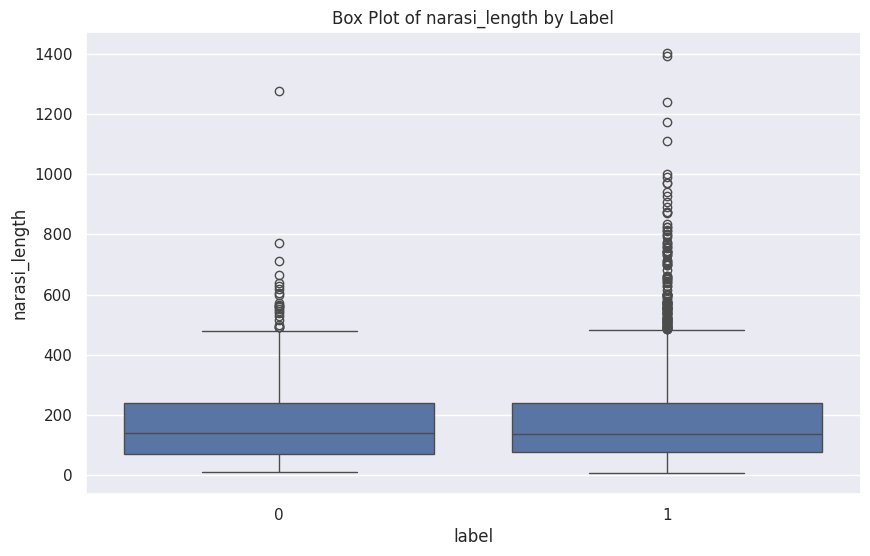

In [41]:
#Box Plot Numerical Column by Label
for column in numerical_df.columns:
    if column != 'label':
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='label', y=column, data=df)
        plt.title(f'Box Plot of {column} by Label')
        plt.show()

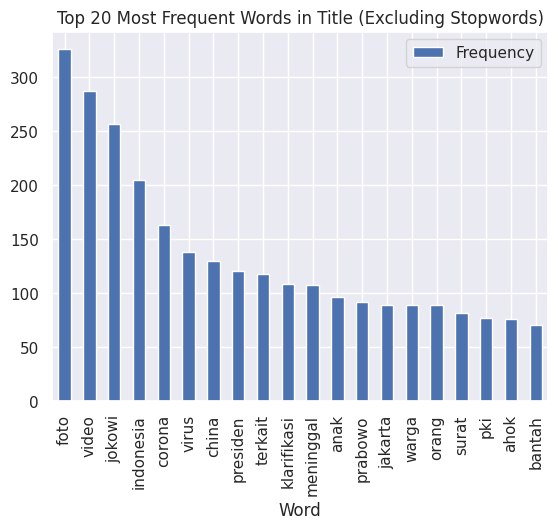

In [42]:
# Tokenize the 'judul' text and remove stopwords
all_words = ' '.join(df['judul'].dropna()).lower().split()
filtered_words = [word for word in all_words if word not in stop_words and word.isalpha()]

# Count the occurrences of each word
word_freq = Counter(filtered_words)

# Create a DataFrame with the word frequencies
word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plot the most frequent words
word_freq_df.head(20).plot(x='Word', y='Frequency', kind='bar')
plt.title('Top 20 Most Frequent Words in Title (Excluding Stopwords)')
plt.show()

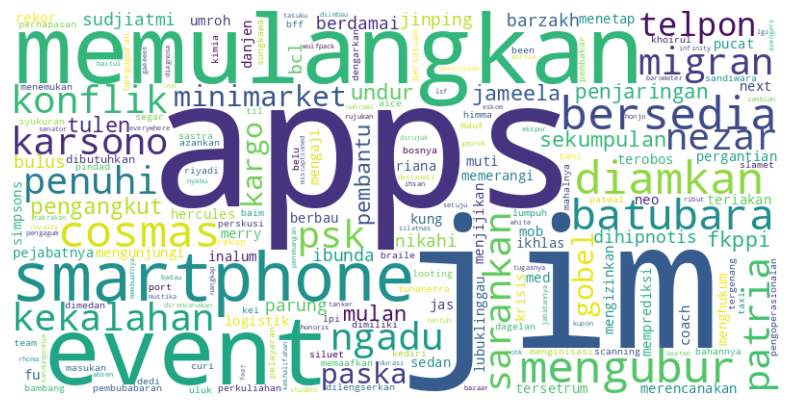

In [43]:
# Check for OOV (out-of-vocabulary) words
rare_words = {word: count for word, count in word_freq.items() if count == 1}

OOV_WordCloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(rare_words)
plt.figure(figsize=(10,5))
plt.imshow(OOV_WordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#WordCloud besar-> Berdasarkan urutan muncul di dictionary rare_words

In [44]:
for word in list(rare_words)[:10]:
  print(word)

apps
jim
memulangkan
event
smartphone
mengubur
diamkan
bersedia
cosmas
batubara


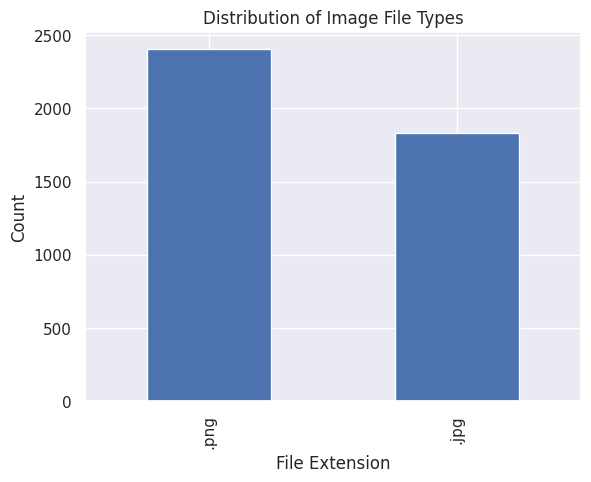

In [45]:
# Distribution of Image File Types
df['file_extension'] = df['nama file gambar'].str.extract(r'(\.\w+)$')[0]
file_type_counts = df['file_extension'].value_counts()

file_type_counts.plot(kind='bar')
plt.title('Distribution of Image File Types')
plt.xlabel('File Extension')
plt.ylabel('Count')
plt.show()

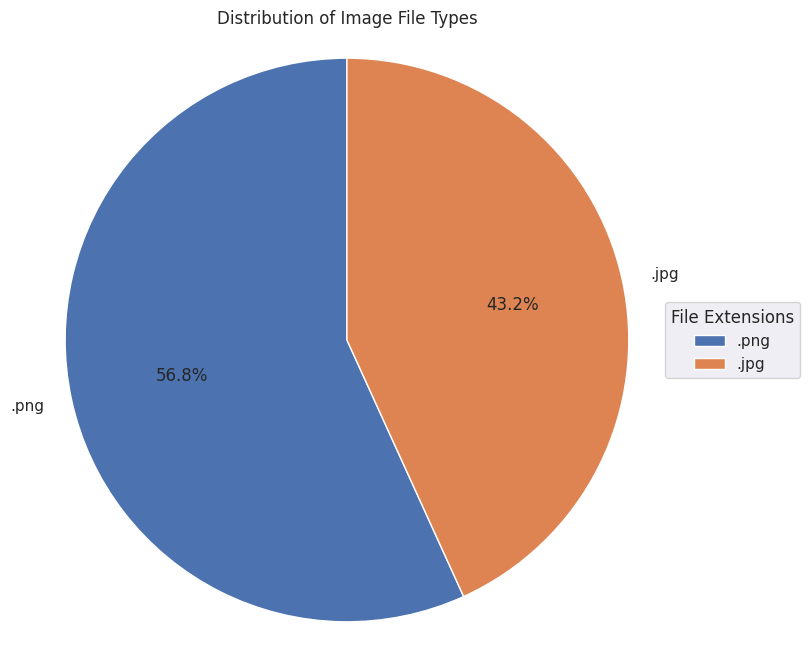

In [46]:
# Distribution of Image File Types
df['file_extension'] = df['nama file gambar'].str.extract(r'(\.\w+)$')[0]
file_type_counts = df['file_extension'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
plt.pie(file_type_counts, labels=file_type_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Image File Types')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.

# Optional: add a legend if you have many file types
plt.legend(file_type_counts.index, title="File Extensions", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

In [47]:
#Distribution of language types if any
def detect_languages(text):
  try:
    return detect(text)
  except:
    return 'Unknown'

# Make temporary dataframe for languages
tmp_df = df.copy()

tmp_df['languages_narasi'] = tmp_df['narasi'].apply(detect_languages)
tmp_df['languages_judul'] = tmp_df['judul'].apply(detect_languages)

In [48]:
print("Languages example in narasi data:\n")
for lang in tmp_df['languages_narasi'].unique():
    example_text = tmp_df[tmp_df['languages_narasi'] == lang]['narasi'].iloc[0]  # Get the first example of each language
    print(f"Language: {lang}, Example: {example_text}")

print("\nLangauges example in judul data:\n\n")
for lang in tmp_df['languages_judul'].unique():
    example_text = tmp_df[tmp_df['languages_judul'] == lang]['judul'].iloc[0]  # Get the first example of each language
    print(f"Language: {lang}, Example: {example_text}")

Languages example in narasi data:

Language: en, Example: A caller to a radio talk show recently shared that his wife was hospitalized n told she had COVID n only a couple of days left to live . A doctor friend suggested she be tested for legionnaires disease because she wore the same mask every day all day long . Turns out it WAS legionnaires disease from the moisture n bacteria in her mask . She was given antibiotics n within two days was better . WHAT IF these ‘spikes’ in COVID are really something else due to ‘mask induced infections’ .??🤔🤔🤔
Language: id, Example: Yth.Seluruh Anggota Grup Sesuai Instruksi Gubernur Jawa Tengah Hasil Rapat Tim Gugus Tugas Covid 19 Jateng sbb:
Language: tl, Example: Kadrun kalo lihat foto ini panas dingin . .
Language: de, Example: LIHATLAH MEREKA SUDAH MEMPERSIAPKAN DIRI DENGAN BAIK UNTUK MENGUASAI NEGRI INI!
Language: hu, Example: CORONA IS A HOAX
Language: et, Example: Ketika Emosi Dominasi Politik


Language: sw, Example: Kwik Kian Gie
Language: b

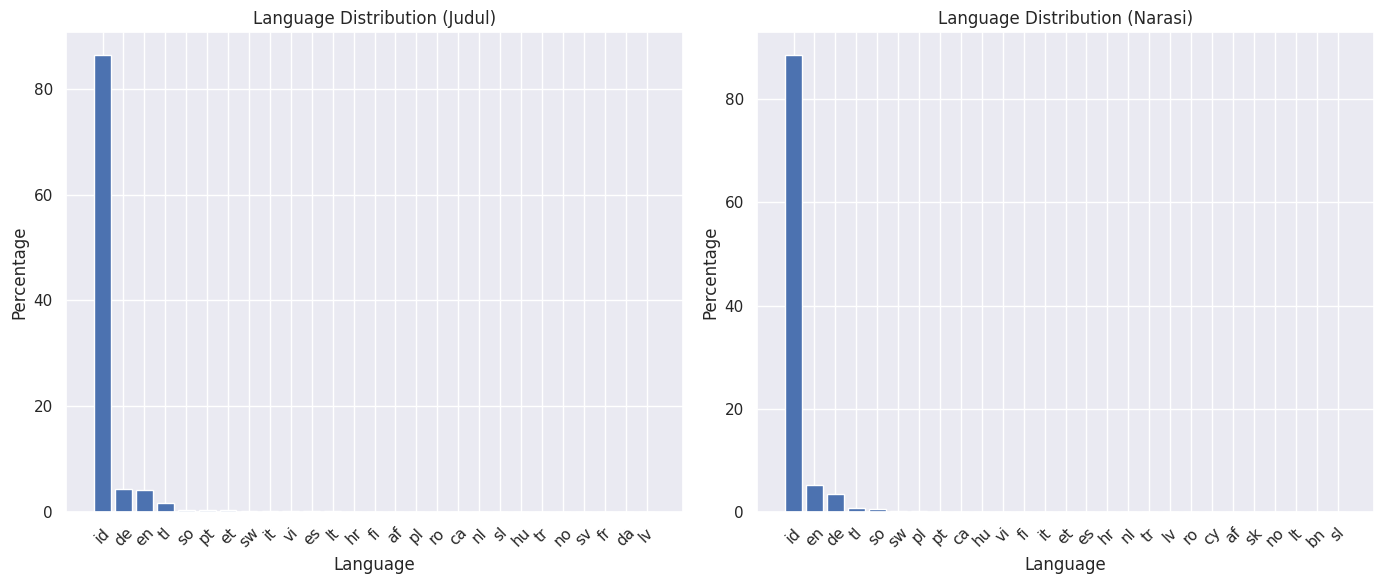

In [49]:
language_distribution_judul = tmp_df['languages_judul'].value_counts(normalize=True) * 100
language_distribution_narasi = tmp_df['languages_narasi'].value_counts(normalize=True) * 100

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

axes[0].bar(language_distribution_judul.index, language_distribution_judul.values)
axes[0].set_xlabel('Language')
axes[0].set_ylabel('Percentage')
axes[0].set_title('Language Distribution (Judul)')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(language_distribution_narasi.index, language_distribution_narasi.values)
axes[1].set_xlabel('Language')
axes[1].set_ylabel('Percentage')
axes[1].set_title('Language Distribution (Narasi)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [50]:
compare_df = pd.concat([pd.DataFrame(language_distribution_judul),pd.DataFrame(language_distribution_narasi)],axis=1)
print(compare_df)

    proportion  proportion
id   86.362562   88.489719
de    4.396124    3.521626
en    4.159773    5.199716
tl    1.796266    0.732687
so    0.449066    0.614512
pt    0.378161    0.118175
et    0.330891    0.070905
sw    0.283621    0.212716
it    0.236351    0.070905
vi    0.212716    0.094540
es    0.212716    0.070905
lt    0.141810    0.023635
hr    0.118175    0.047270
fi    0.118175    0.070905
af    0.094540    0.023635
pl    0.094540    0.141810
ro    0.094540    0.023635
ca    0.070905    0.118175
nl    0.070905    0.047270
sl    0.070905    0.023635
hu    0.070905    0.094540
tr    0.070905    0.047270
no    0.047270    0.023635
sv    0.047270         NaN
fr    0.023635         NaN
da    0.023635         NaN
lv    0.023635    0.047270
cy         NaN    0.023635
sk         NaN    0.023635
bn         NaN    0.023635


# Preprocessing

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4231 entries, 2020-08-17 to 2020-07-20
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                4231 non-null   int64 
 1   label             4231 non-null   int64 
 2   judul             4231 non-null   object
 3   narasi            4231 non-null   object
 4   nama file gambar  4231 non-null   object
 5   judul_length      4231 non-null   int64 
 6   narasi_length     4231 non-null   int64 
 7   file_extension    4231 non-null   object
dtypes: int64(4), object(4)
memory usage: 297.5+ KB


In [52]:
# Seperate indonesian text with others
indiciesToDrop = []

for i, row in df.iterrows():
  if detect(row['narasi']) != 'id' or detect(row['judul']) != 'id':
    indiciesToDrop.append(i)

filtered = df.drop(indiciesToDrop)

In [53]:
filtered.reset_index(inplace=True)
filtered

,tanggal,ID,label,judul,narasi,nama file gambar,judul_length,narasi_length,file_extension
0,2020-07-17,461,1,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,461.png,131,111,.png
1,2020-07-08,550,1,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",550.png,104,773,.png
2,2019-12-24,2226,1,Video Polisi china telah menganiaya wanita uig...,Polisi china telah menganiaya wanita uighur le...,2226.png,77,226,.png
3,2019-10-13,2588,1,"Akhirnya, Jokowi bersedia mengundurkan diri","Akhirnya, Jokowi bersedia mengundurkan diri.\n...",2588.png,43,65,.png
4,2019-07-29,2987,1,Dirut PT Agung Podomoro Land Cosmas Batubara M...,Turut berduka cita atas\n meninggalnya Pejuang...,2987.png,60,221,.png
...,...,...,...,...,...,...,...,...,...
1728,2017-05-26,998297,1,Pengacara Hotman Paris Hutapea Jadi Kuasa Huku...,Pengacara Hotman Paris Hutapea Jadi Kuasa Huku...,998297.jpg,67,67,.jpg
1729,2017-05-21,998306,1,: Kemendagri Cabut Perda Minuman Keras,Kegeraman sudah memuncak. Inikah kado kebangki...,998306.png,38,203,.png
1730,2016-03-03,999251,1,Jembatan Soekarno-Hatta di Kota Malang Melengkung,Jembatan Soekarno-Hatta di Kota Malang Melengkung,999251.jpg,49,49,.jpg
1731,2016-01-17,999287,1,: KPK Dilarang Membawa Brimob Bersenjata Masuk...,KPK Dilarang Membawa Brimob Bersenjata Masuk G...,999287.jpg,57,55,.jpg


In [54]:
filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1733 entries, 0 to 1732
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tanggal           1733 non-null   datetime64[ns]
 1   ID                1733 non-null   int64         
 2   label             1733 non-null   int64         
 3   judul             1733 non-null   object        
 4   narasi            1733 non-null   object        
 5   nama file gambar  1733 non-null   object        
 6   judul_length      1733 non-null   int64         
 7   narasi_length     1733 non-null   int64         
 8   file_extension    1733 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 122.0+ KB


In [55]:
# Remove/Filter any emojis

def extract_emojis(text):
  return ''.join(c for c in text if emoji.is_emoji(c))

emoji_in_df = filtered[filtered['judul'].apply(lambda x: extract_emojis(x) != '') | filtered['narasi'].apply(lambda x: extract_emojis(x) != '')]

In [56]:
emoji_in_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, 54 to 1671
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tanggal           36 non-null     datetime64[ns]
 1   ID                36 non-null     int64         
 2   label             36 non-null     int64         
 3   judul             36 non-null     object        
 4   narasi            36 non-null     object        
 5   nama file gambar  36 non-null     object        
 6   judul_length      36 non-null     int64         
 7   narasi_length     36 non-null     int64         
 8   file_extension    36 non-null     object        
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 2.8+ KB


There is 72 rows that contains emoji, lets remove them

In [57]:
def remove_emoji(text):
  return emoji.replace_emoji(text,replace = '')

In [58]:
cleaned_df = filtered.copy()
cleaned_df['judul']= filtered['judul'].apply(remove_emoji)
cleaned_df['narasi'] = cleaned_df['narasi'].apply(remove_emoji)

In [59]:
cleaned_df[cleaned_df['judul'].apply(lambda x: extract_emojis(x) != '') | cleaned_df['narasi'].apply(lambda x: extract_emojis(x) != '')].info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tanggal           0 non-null      datetime64[ns]
 1   ID                0 non-null      int64         
 2   label             0 non-null      int64         
 3   judul             0 non-null      object        
 4   narasi            0 non-null      object        
 5   nama file gambar  0 non-null      object        
 6   judul_length      0 non-null      int64         
 7   narasi_length     0 non-null      int64         
 8   file_extension    0 non-null      object        
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 0.0+ bytes


In [60]:
# Stemmer and stopwords
stemmer = StemmerFactory().create_stemmer()
nltk_stopwords = set(stopwords.words('indonesian')) #nltk version
sastrawi_stopwords = set(StopWordRemoverFactory().get_stop_words()) #Sastrawi version
stop_words = nltk_stopwords.union(sastrawi_stopwords) #Combined
stop_words = list(stop_words) # Make it back into a list
stop_words += ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya']

In [61]:
X = cleaned_df['narasi'] + ' ' + cleaned_df['judul']
X = X.to_frame()
y = cleaned_df['label']

In [62]:
X

,0
0,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...
1,"Maaf Mas2 dan Mbak2, ini bukan politik, tapi k..."
2,Polisi china telah menganiaya wanita uighur le...
3,"Akhirnya, Jokowi bersedia mengundurkan diri.\n..."
4,Turut berduka cita atas\n meninggalnya Pejuang...
...,...
1728,Pengacara Hotman Paris Hutapea Jadi Kuasa Huku...
1729,Kegeraman sudah memuncak. Inikah kado kebangki...
1730,Jembatan Soekarno-Hatta di Kota Malang Melengk...
1731,KPK Dilarang Membawa Brimob Bersenjata Masuk G...


In [63]:
y

0       1
1       1
2       1
3       1
4       1
       ..
1728    1
1729    1
1730    1
1731    1
1732    1
Name: label, Length: 1733, dtype: int64

In [64]:
word_lists = []
for text in X[0]:
  word_list = [stemmer.stem(word) for word in word_tokenize(text.lower()) if word not in punctuation and word not in stop_words and word.isalpha()]
  processed_text = ' '.join(word_list)
  word_lists.append(processed_text)

# Make temp files to train fasttext
train_path = 'train_text.txt'

# Export to text
with open(train_path, 'w') as file:
    for text in word_lists:
      file.write(text+'\n')


## Embeddings

In [65]:
# -> Balance data based on labels
# In this case i am using SMOTEEN (SMOTE with ENN)
resample = SMOTETomek(random_state=7873)

## Fasttext

In [66]:
# Combined word embedding for training data for fasttext mode
model_fasttext = fasttext.train_unsupervised(train_path, model = 'cbow')

In [67]:
model_fasttext.save_model('fasttext_model.bin')

In [68]:
def get_text_embedding_fasttext(text):
    tokens = text.split()
    embeddings = [model_fasttext.get_word_vector(token) for token in tokens if token in model_fasttext]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model_fasttext.get_dimension())

# Combine FastText embeddings for text data in X
def combine_fasttext_embeddings(X):
    return np.array([get_text_embedding_fasttext(text) for text in X])

In [69]:
# FastText embeddings
X_fasttext = combine_fasttext_embeddings(X[0])

In [70]:
X_fasttext

array([[-0.08888238,  0.14409071,  0.02635166, ...,  0.05635939,
         0.04661055,  0.21156123],
       [-0.09874308,  0.15989409,  0.02870698, ...,  0.06130767,
         0.05049697,  0.23350289],
       [-0.09536289,  0.15462549,  0.02761191, ...,  0.05951273,
         0.04923011,  0.2257814 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [71]:
#Resample
X_fasttext, y_fasttext = resample.fit_resample(X_fasttext, y)

In [72]:
X_fasttext.shape,y_fasttext.shape

((2656, 100), (2656,))

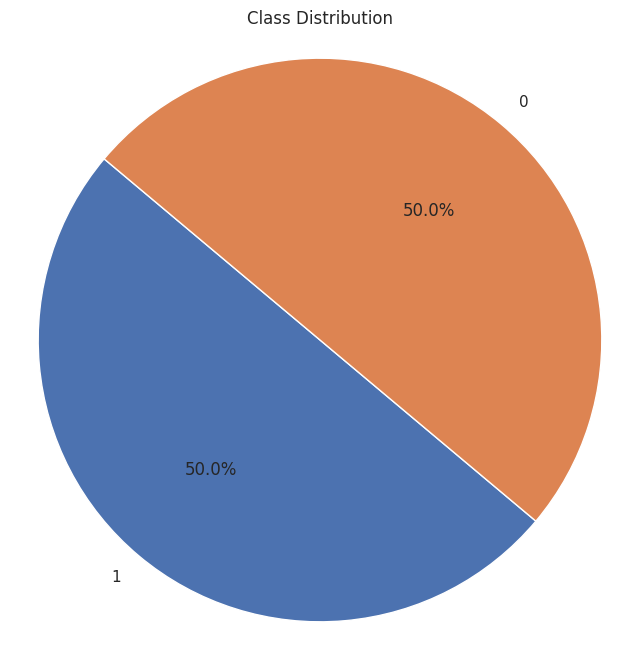

In [73]:
class_counts = y_fasttext.value_counts()
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.axis('equal')
plt.show()

## TF-IDF

In [74]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(word_lists)

# Vocabulary (words) with their corresponding TF-IDF vectors
vocabulary = tfidf_vectorizer.get_feature_names_out()

# TF-IDF vectors for each word in the vocabulary
word_embeddings = tfidf_vectorizer.idf_

In [75]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words=stop_words)
X_tfidf = vectorizer.fit_transform(X[0])

In [76]:
# Resample
X_tfidf, y_tfidf = resample.fit_resample(X_tfidf, y)

In [77]:
X_tfidf.shape, y_tfidf.shape

((2726, 10833), (2726,))

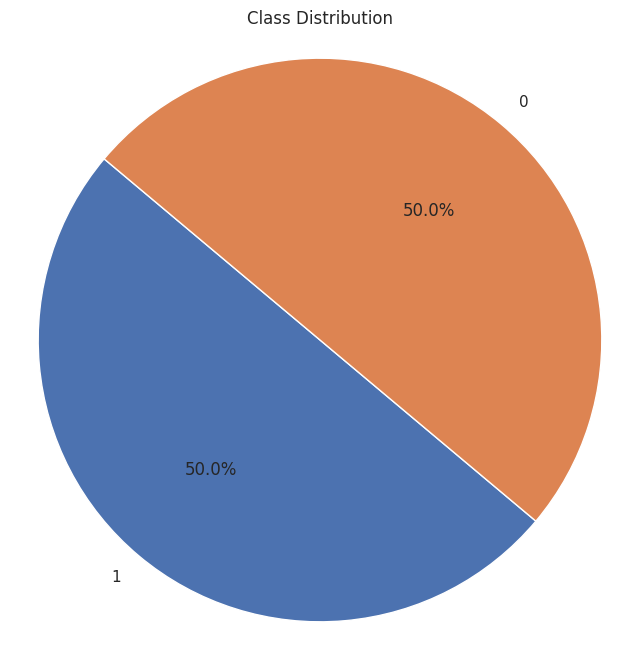

In [78]:
class_counts = y_tfidf.value_counts()
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.axis('equal')
plt.show()

## Train-Test Split

In [79]:
# Split for fasttext
X_ft_train, X_ft_test, y_ft_train, y_ft_test = train_test_split(X_fasttext,y_fasttext, test_size=0.3, random_state=42, stratify=y_fasttext)

In [80]:
y_ft_train = y_ft_train.reset_index(drop=True)
y_ft_test = y_ft_test.reset_index(drop=True)

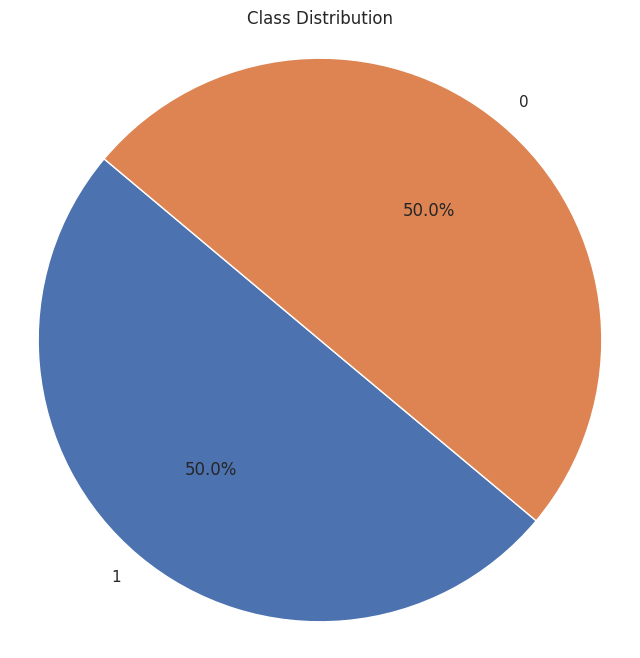

In [81]:
class_counts = y_ft_train.value_counts()
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.axis('equal')
plt.show()

In [82]:
# Split for TF-IDF
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf,y_tfidf,test_size=0.3, random_state=True, stratify=y_tfidf)

In [83]:
y_tfidf_train = y_tfidf_train.reset_index(drop=True)
y_tfidf_test = y_tfidf_test.reset_index(drop=True)

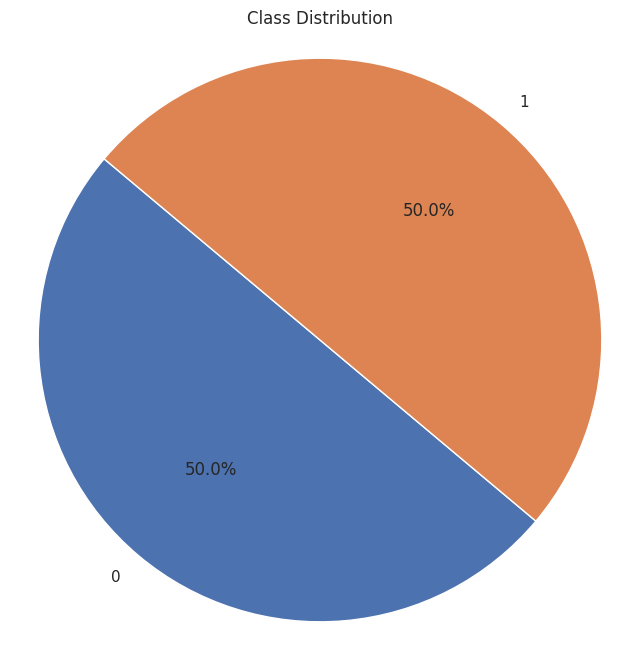

In [84]:
class_counts = y_tfidf_test.value_counts()
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.axis('equal')
plt.show()

# Model
In our model we will use Continous Bag Of Words (CBOW) for our fasttext model and TF-IDF for our word embeding. On the other hand we will use both random forest and SVM for our classifications needs.

In [85]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.show()

# Define cross-validation for SVM
def run_cross_validation_svm(X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []
    for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Train SVM classifier
        svm_classifier = SVC(kernel='linear',probability=True)
        svm_classifier.fit(X_train, y_train)

        # Predict on validation set
        y_pred = svm_classifier.predict(X_val)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_val, y_pred)
        report = classification_report(y_val, y_pred, output_dict=True, zero_division=1)
        precision = report['1']['precision']
        recall = report['1']['recall']
        f1 = report['1']['f1-score']

        # Calculate ROC AUC score
        y_prob = svm_classifier.predict_proba(X_val)[:, 1]
        roc_auc = roc_auc_score(y_val, y_prob)

        # Append scores
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)

        # Plot confusion matrix
        plot_confusion_matrix(y_val, y_pred,labels=[0,1])

        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
        roc_display.plot()
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

    # Calculate average scores
    avg_accuracy = np.mean(accuracy_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    avg_roc_auc = np.mean(roc_auc_scores)

    return avg_accuracy, avg_precision, avg_recall, avg_f1, avg_roc_auc

# Define cross-validation for Random Forest
def run_cross_validation_rf(X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []
    for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Train Random Forest classifier
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_classifier.fit(X_train, y_train)

        # Predict on validation set
        y_pred = rf_classifier.predict(X_val)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_val, y_pred)
        report = classification_report(y_val, y_pred, output_dict=True, zero_division=1)
        precision = report['1']['precision']
        recall = report['1']['recall']
        f1 = report['1']['f1-score']

        # Calculate ROC AUC score
        y_prob = rf_classifier.predict_proba(X_val)[:, 1]
        roc_auc = roc_auc_score(y_val, y_prob)

        # Append scores
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)

        # Plot confusion matrix
        plot_confusion_matrix(y_val, y_pred, labels=[0, 1])

        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
        roc_display.plot()
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

    # Calculate average scores
    avg_accuracy = np.mean(accuracy_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    avg_roc_auc = np.mean(roc_auc_scores)

    return avg_accuracy, avg_precision, avg_recall, avg_f1, avg_roc_auc


# Validation

TF-IDF + SVM Classifier:


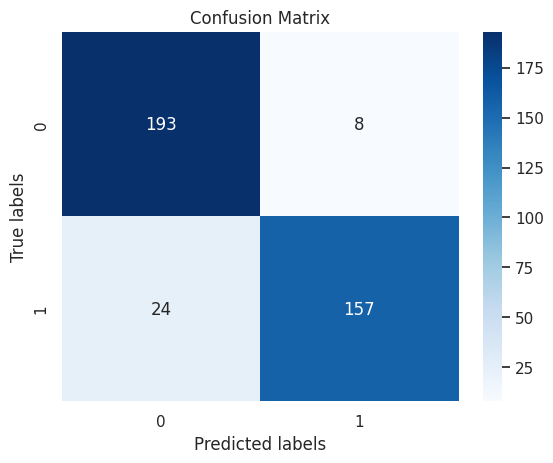

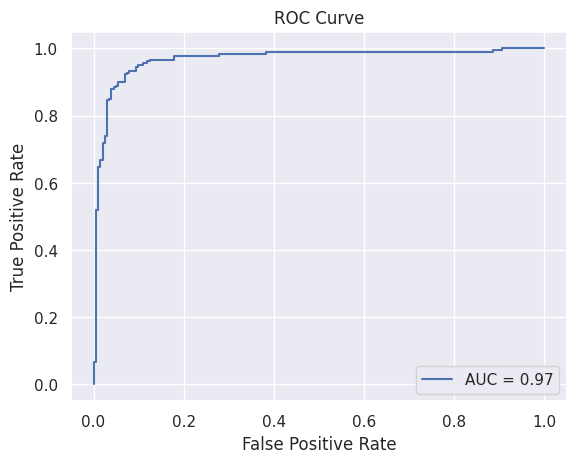

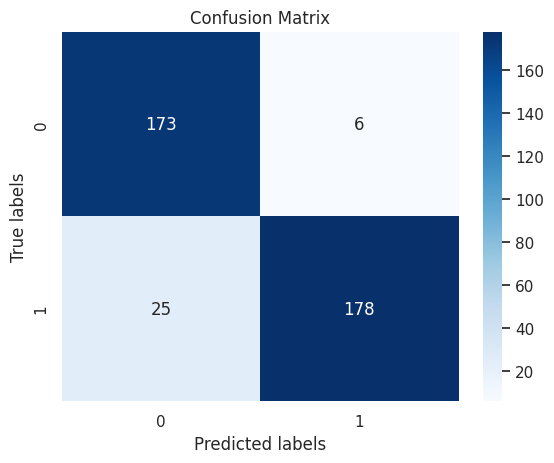

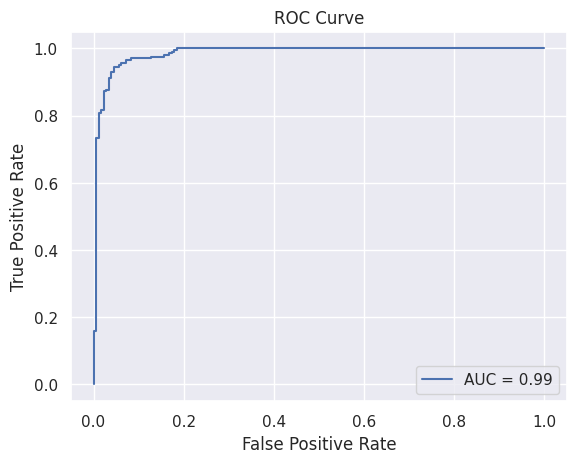

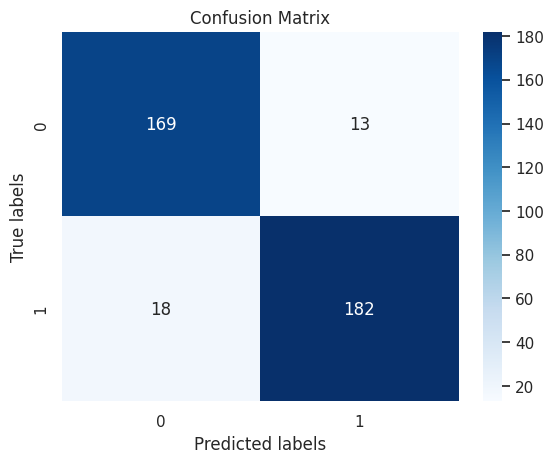

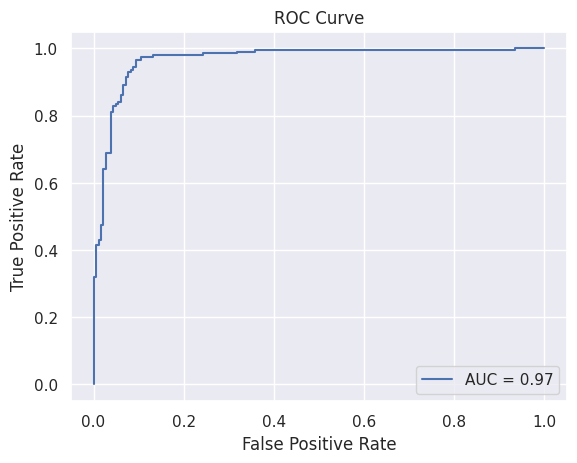

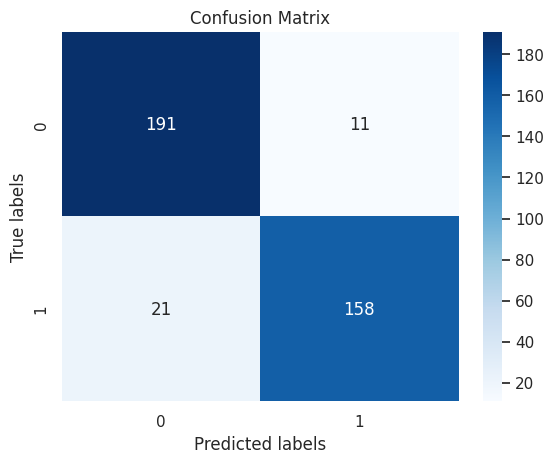

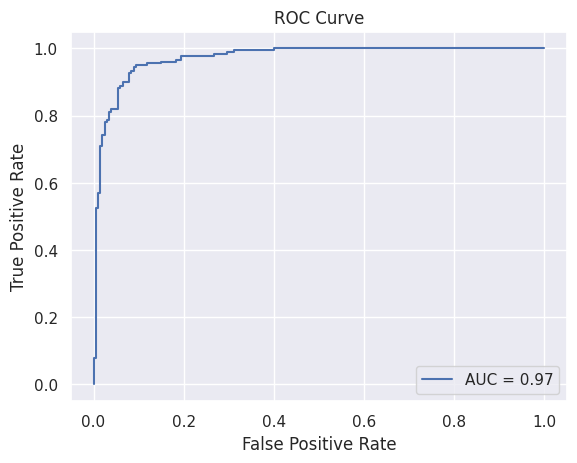

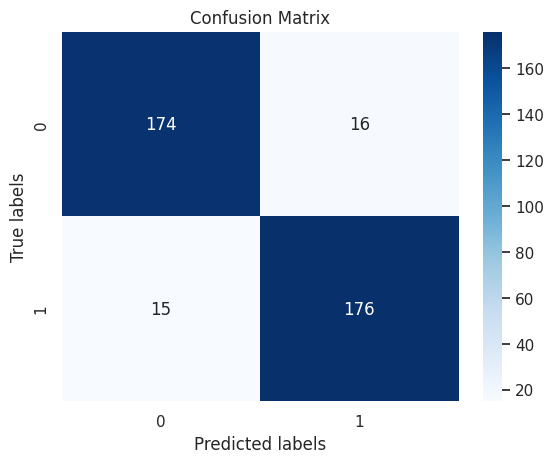

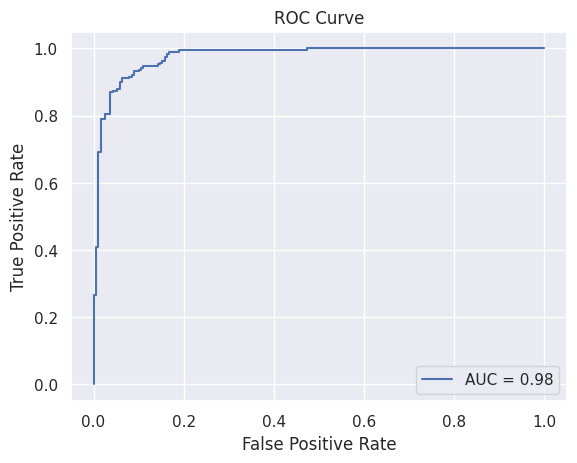

Average Accuracy: 0.9177144741724039
Average Precision: 0.9407635396933056
Average Recall: 0.8916796276779436
Average F1-score: 0.9152072216533027
Average ROC AUC score: 0.9736319693115052

FastText + SVM Classifier:


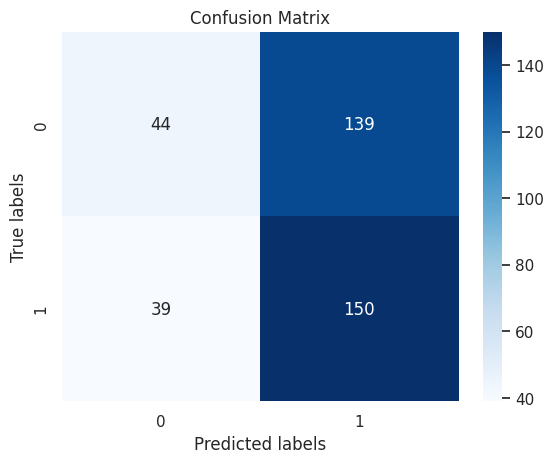

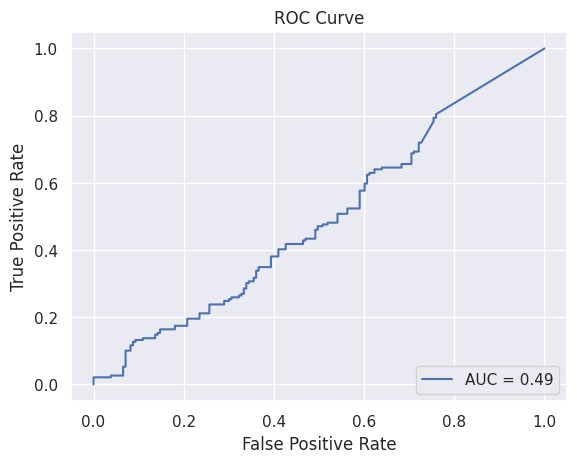

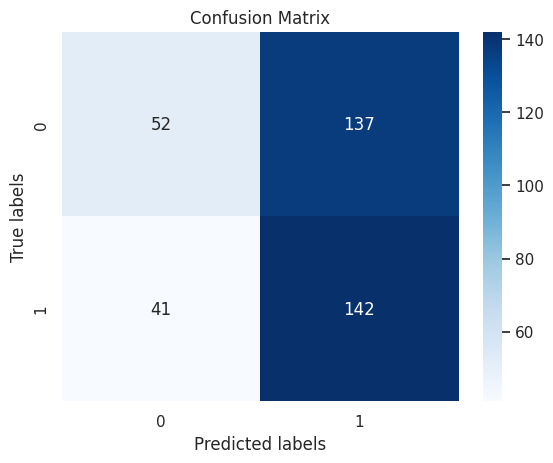

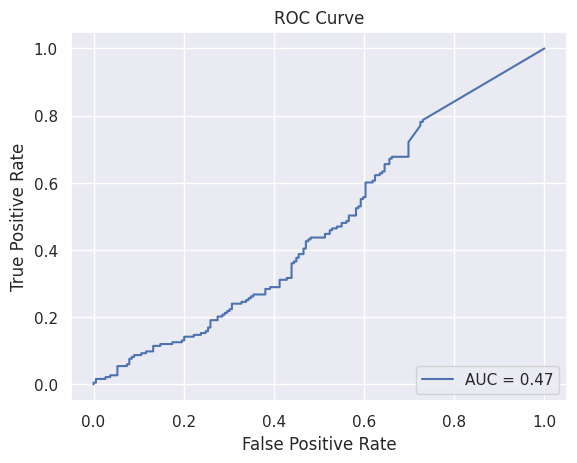

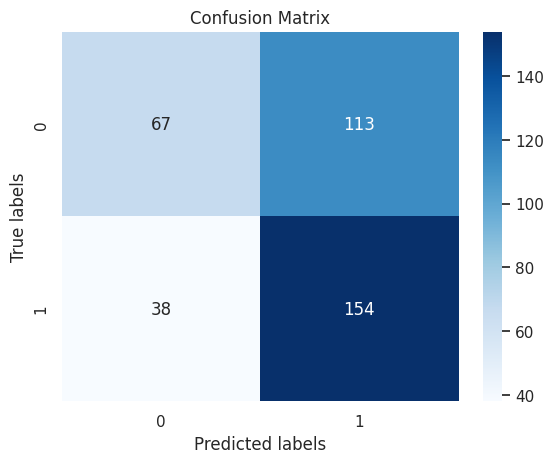

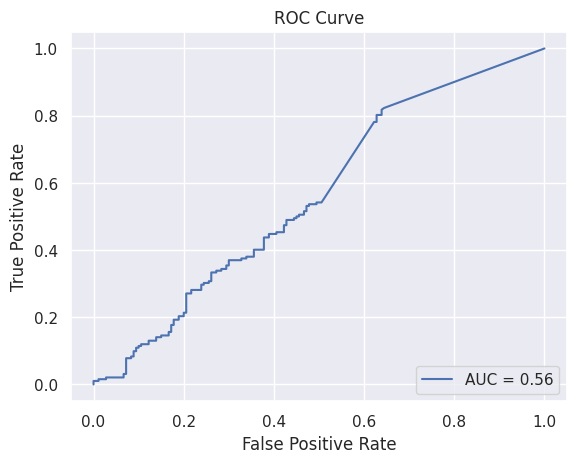

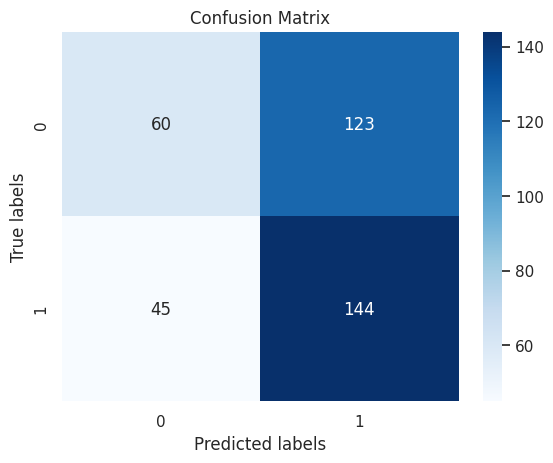

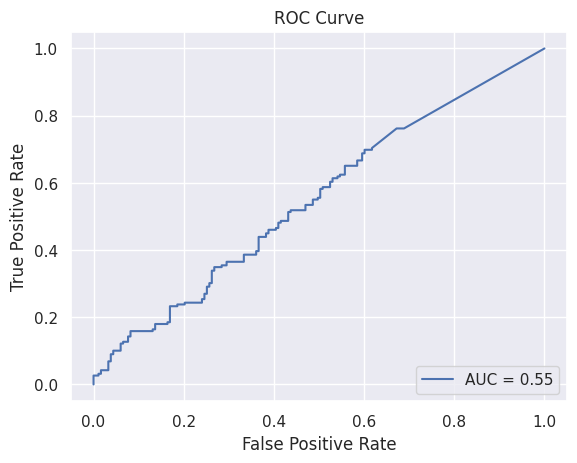

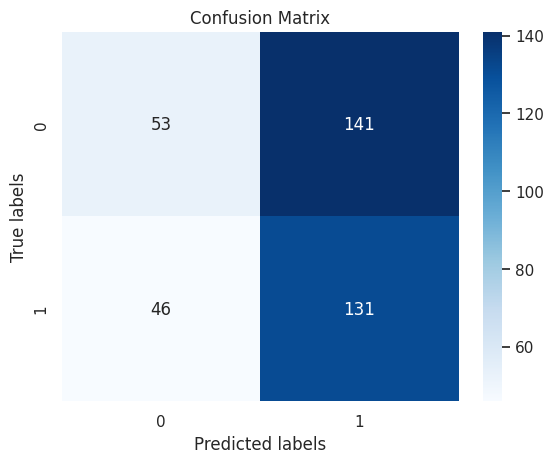

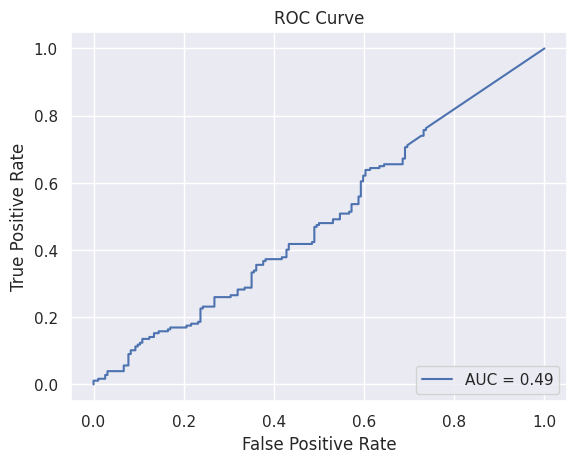

Average Accuracy: 0.5362881488566211
Average Precision: 0.5251428462635792
Average Recall: 0.7747416334784354
Average F1-score: 0.6256911041895676
Average ROC AUC score: 0.5127437384127165

TF-IDF + Random Forest Classifier:


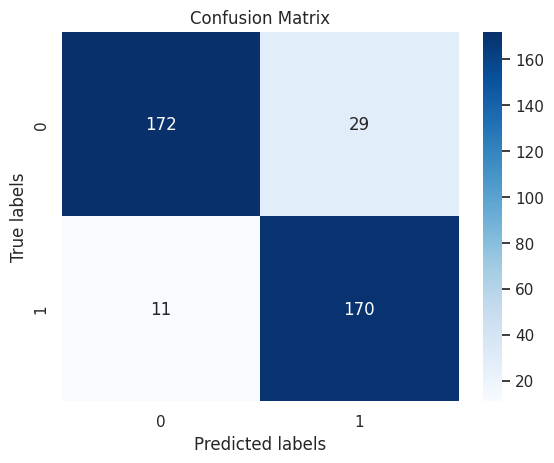

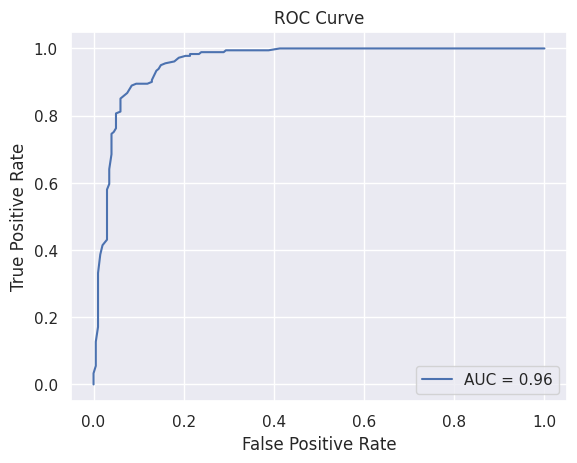

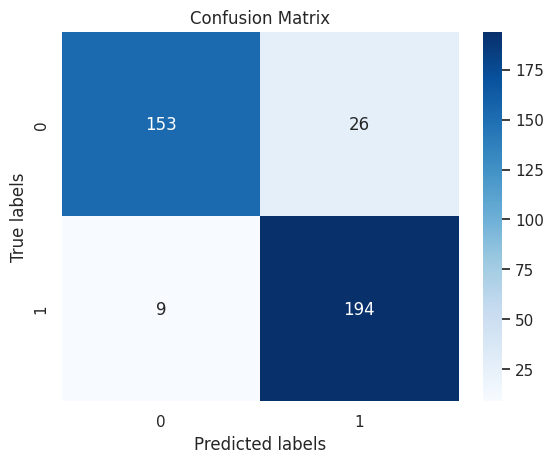

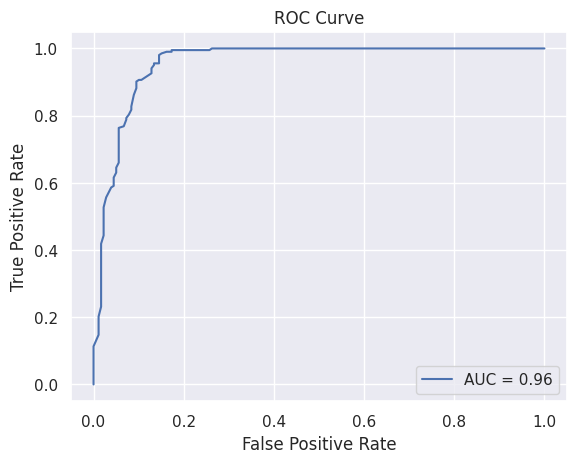

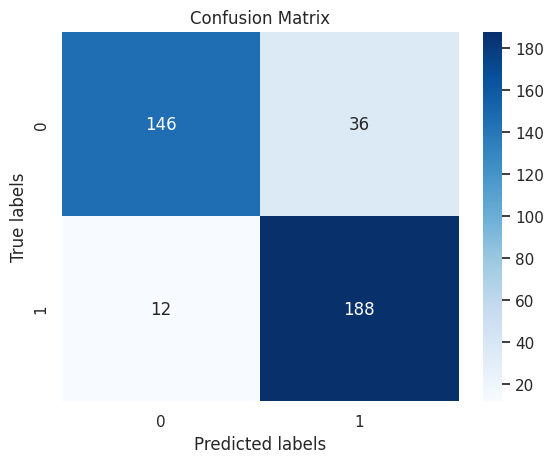

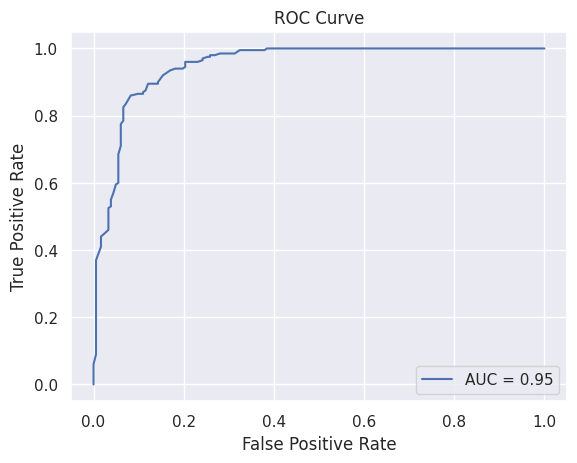

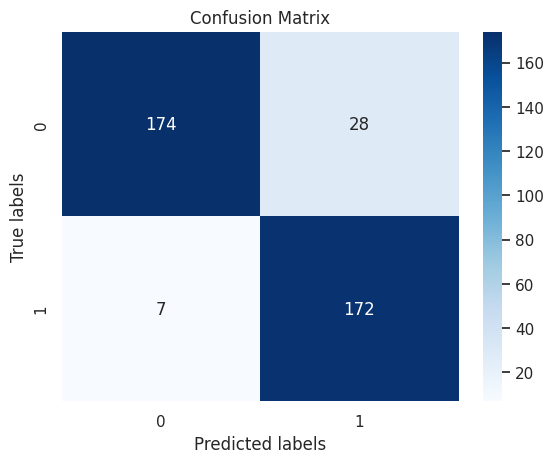

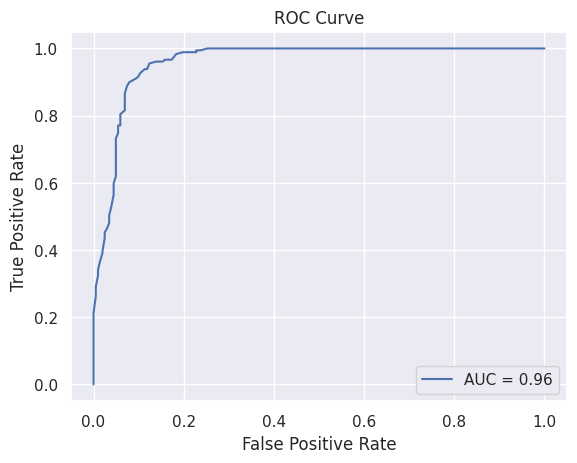

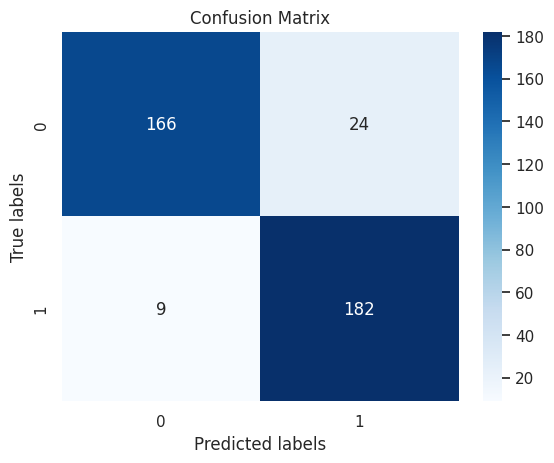

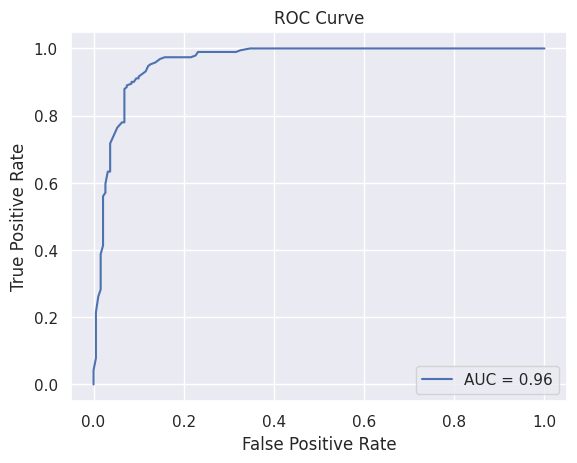

Average Accuracy: 0.899906556183095
Average Precision: 0.8637740797037768
Average Recall: 0.949732995973599
Average F1-score: 0.9046630534994928
Average ROC AUC score: 0.9570635048482373

FastText + Random Forest Classifier:


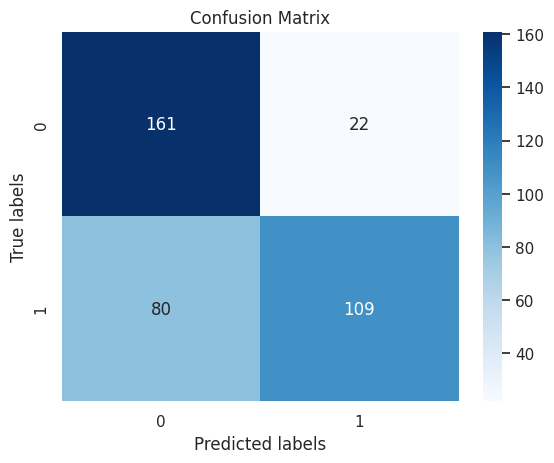

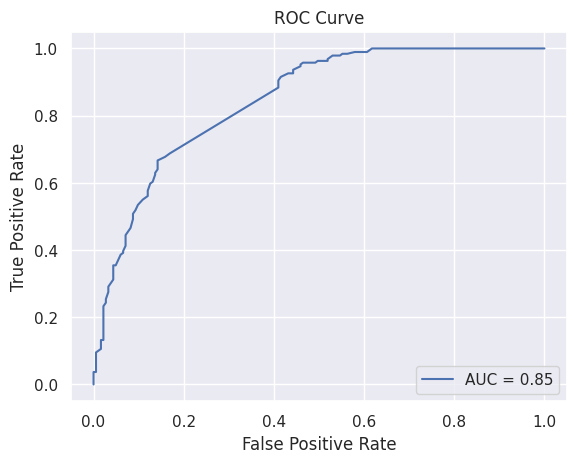

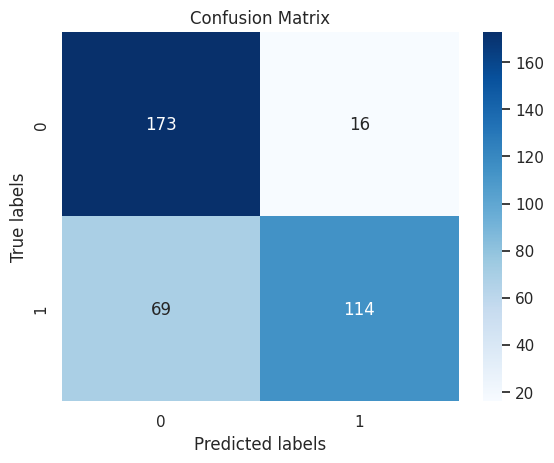

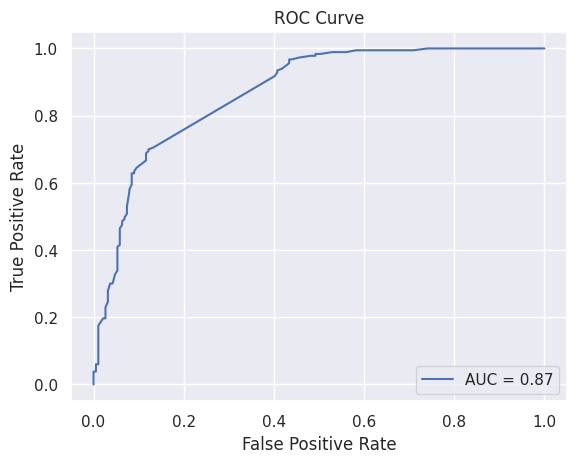

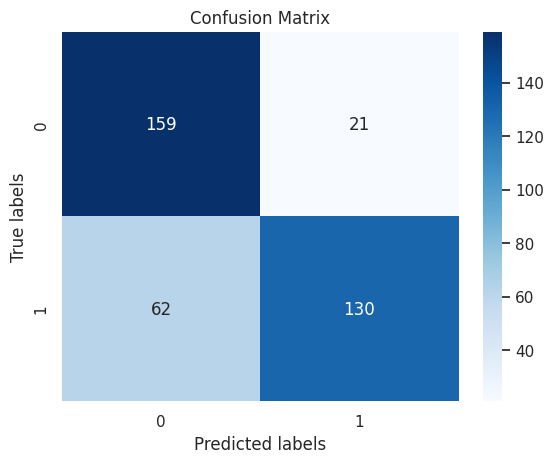

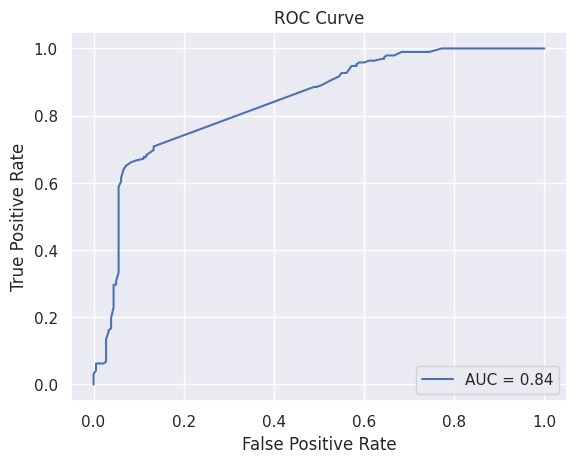

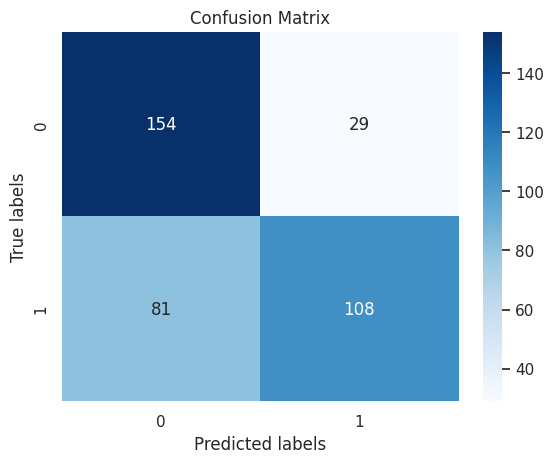

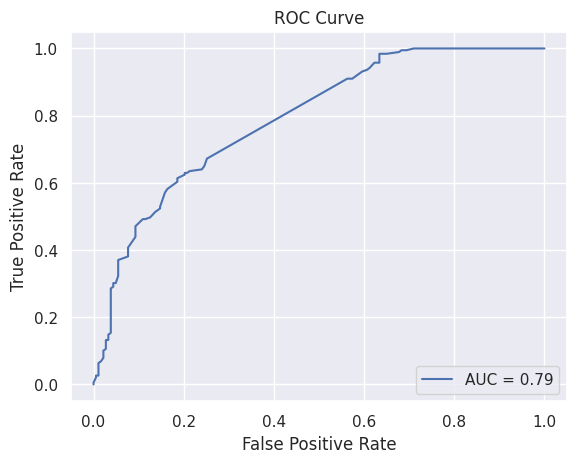

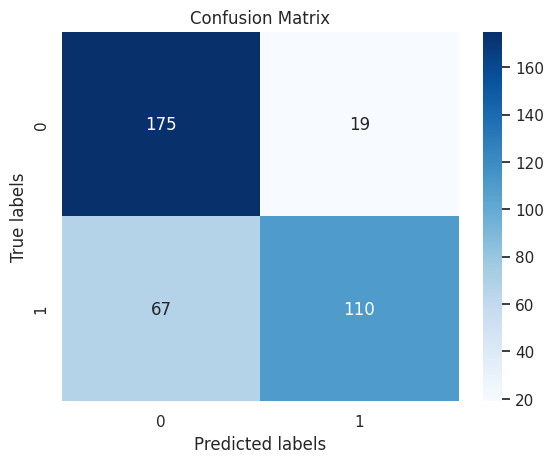

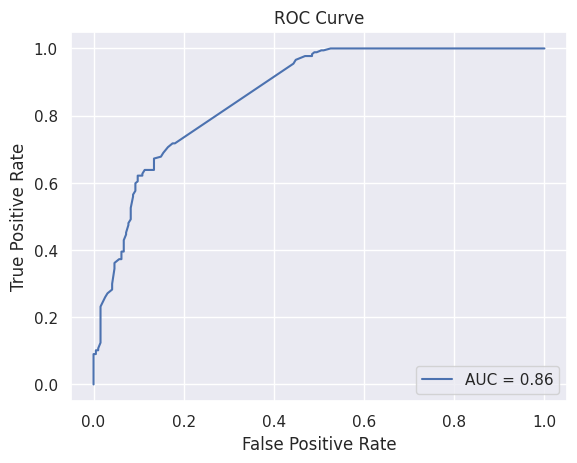

Average Accuracy: 0.7493377387473552
Average Precision: 0.8421891288242065
Average Recall: 0.6139302455414569
Average F1-score: 0.7098465865972561
Average ROC AUC score: 0.8430903607829305


In [86]:
# Model evaluation
print("TF-IDF + SVM Classifier:")
avg_accuracy_tfidf_svm, avg_precision_tfidf_svm, avg_recall_tfidf_svm, avg_f1_tfidf_svm, avg_roc_auc_tfidf_svm = run_cross_validation_svm(X_tfidf_train, y_tfidf_train)
print("Average Accuracy:", avg_accuracy_tfidf_svm)
print("Average Precision:", avg_precision_tfidf_svm)
print("Average Recall:", avg_recall_tfidf_svm)
print("Average F1-score:", avg_f1_tfidf_svm)
print("Average ROC AUC score:", avg_roc_auc_tfidf_svm)

print("\nFastText + SVM Classifier:")
avg_accuracy_fasttext_svm, avg_precision_fasttext_svm, avg_recall_fasttext_svm, avg_f1_fasttext_svm, avg_roc_auc_fasttext_svm = run_cross_validation_svm(X_ft_train, y_ft_train)
print("Average Accuracy:", avg_accuracy_fasttext_svm)
print("Average Precision:", avg_precision_fasttext_svm)
print("Average Recall:", avg_recall_fasttext_svm)
print("Average F1-score:", avg_f1_fasttext_svm)
print("Average ROC AUC score:", avg_roc_auc_fasttext_svm)

print("\nTF-IDF + Random Forest Classifier:")
avg_accuracy_tfidf_rf, avg_precision_tfidf_rf, avg_recall_tfidf_rf, avg_f1_tfidf_rf, avg_roc_auc_tfidf_rf = run_cross_validation_rf(X_tfidf_train, y_tfidf_train)
print("Average Accuracy:", avg_accuracy_tfidf_rf)
print("Average Precision:", avg_precision_tfidf_rf)
print("Average Recall:", avg_recall_tfidf_rf)
print("Average F1-score:", avg_f1_tfidf_rf)
print("Average ROC AUC score:", avg_roc_auc_tfidf_rf)

print("\nFastText + Random Forest Classifier:")
avg_accuracy_fasttext_rf, avg_precision_fasttext_rf, avg_recall_fasttext_rf, avg_f1_fasttext_rf, avg_roc_auc_fasttext_rf = run_cross_validation_rf(X_ft_train, y_ft_train)
print("Average Accuracy:", avg_accuracy_fasttext_rf)
print("Average Precision:", avg_precision_fasttext_rf)
print("Average Recall:", avg_recall_fasttext_rf)
print("Average F1-score:", avg_f1_fasttext_rf)
print("Average ROC AUC score:", avg_roc_auc_fasttext_rf)

# Test and Evaluations

In [87]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.show()

# Train and evaluate SVM classifier
def evaluate_svm(X_train, X_test, y_train, y_test):
    svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
    svm_classifier.fit(X_train, y_train)

    # Predict on test set
    y_pred = svm_classifier.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1 = report['1']['f1-score']

    # Calculate ROC AUC score
    y_prob = svm_classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_prob)

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, labels=[0, 1])

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    roc_display.plot()
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

    return accuracy, precision, recall, f1, roc_auc

# Train and evaluate Random Forest classifier
def evaluate_rf(X_train, X_test, y_train, y_test):
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Predict on test set
    y_pred = rf_classifier.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1 = report['1']['f1-score']

    # Calculate ROC AUC score
    y_prob = rf_classifier.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_prob)

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, labels=[0, 1])

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    roc_display.plot()
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

    return accuracy, precision, recall, f1, roc_auc


TF-IDF + SVM Classifier:


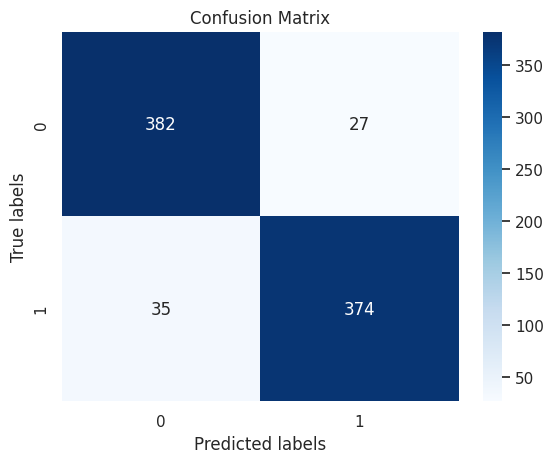

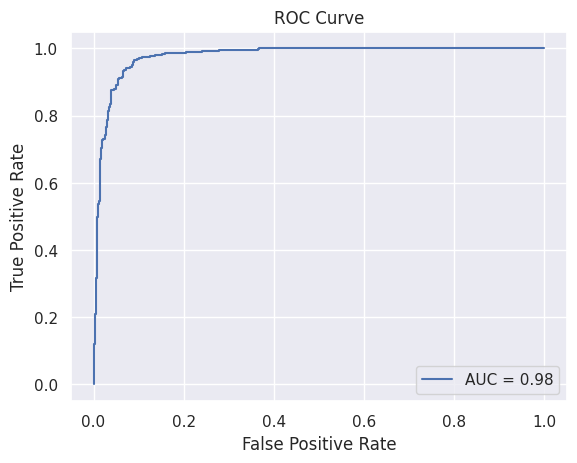

Accuracy: 0.9242053789731052
Precision: 0.9326683291770573
Recall: 0.9144254278728606
F1-score: 0.9234567901234567
ROC AUC score: 0.9773853575719897


In [88]:
#TF-IDF + SVM Classifier
print("TF-IDF + SVM Classifier:")
avg_accuracy_tfidf_svm, avg_precision_tfidf_svm, avg_recall_tfidf_svm, avg_f1_tfidf_svm, avg_roc_auc_tfidf_svm = evaluate_svm(X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test)
print("Accuracy:", avg_accuracy_tfidf_svm)
print("Precision:", avg_precision_tfidf_svm)
print("Recall:", avg_recall_tfidf_svm)
print("F1-score:", avg_f1_tfidf_svm)
print("ROC AUC score:", avg_roc_auc_tfidf_svm)


FastText + SVM Classifier:


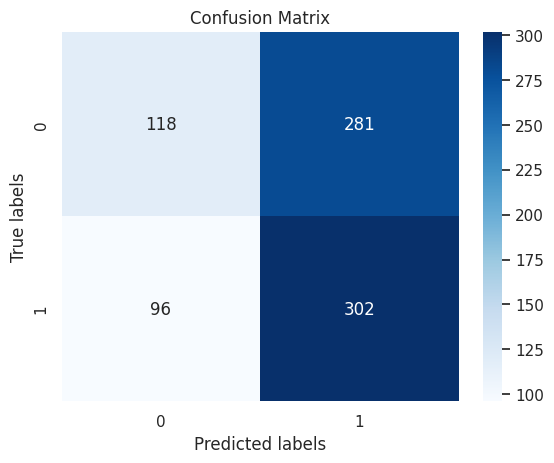

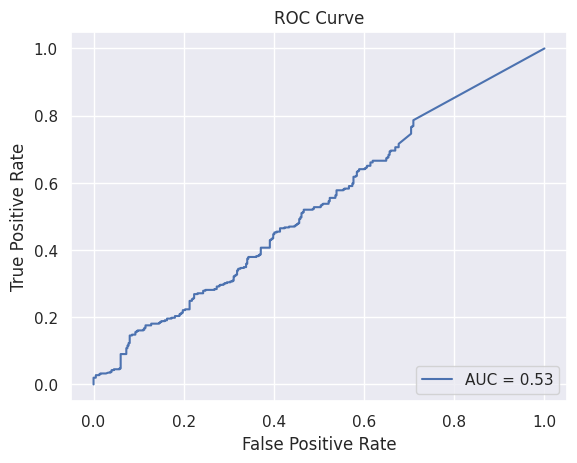

Accuracy: 0.5269761606022585
Precision: 0.5180102915951973
Recall: 0.7587939698492462
F1-score: 0.6156982670744139
ROC AUC score: 0.5322791904384077


In [89]:
#FastText + SVM Classifier
print("\nFastText + SVM Classifier:")
avg_accuracy_fasttext_svm, avg_precision_fasttext_svm, avg_recall_fasttext_svm, avg_f1_fasttext_svm, avg_roc_auc_fasttext_svm = evaluate_svm(X_ft_train, X_ft_test, y_ft_train, y_ft_test)
print("Accuracy:", avg_accuracy_fasttext_svm)
print("Precision:", avg_precision_fasttext_svm)
print("Recall:", avg_recall_fasttext_svm)
print("F1-score:", avg_f1_fasttext_svm)
print("ROC AUC score:", avg_roc_auc_fasttext_svm)


TF-IDF + Random Forest Classifier:


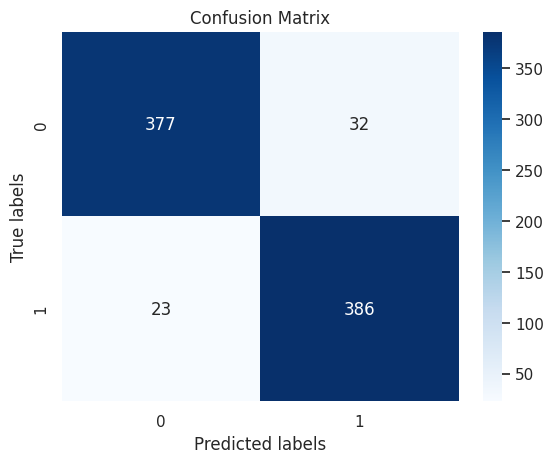

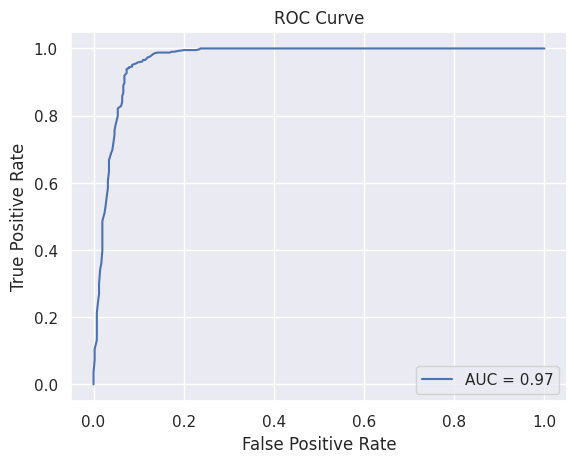

Accuracy: 0.9327628361858191
Precision: 0.9234449760765551
Recall: 0.9437652811735942
F1-score: 0.9334945586457074
ROC AUC score: 0.9670076099497253


In [90]:
#TF-IDF + Random Forest Classifier
print("\nTF-IDF + Random Forest Classifier:")
avg_accuracy_tfidf_rf, avg_precision_tfidf_rf, avg_recall_tfidf_rf, avg_f1_tfidf_rf, avg_roc_auc_tfidf_rf = evaluate_rf(X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test)
print("Accuracy:", avg_accuracy_tfidf_rf)
print("Precision:", avg_precision_tfidf_rf)
print("Recall:", avg_recall_tfidf_rf)
print("F1-score:", avg_f1_tfidf_rf)
print("ROC AUC score:", avg_roc_auc_tfidf_rf)


FastText + Random Forest Classifier:


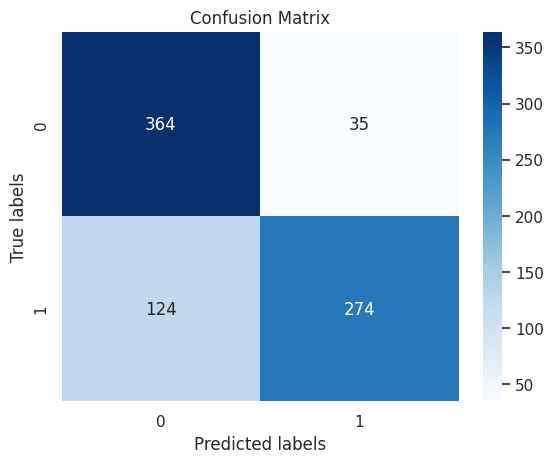

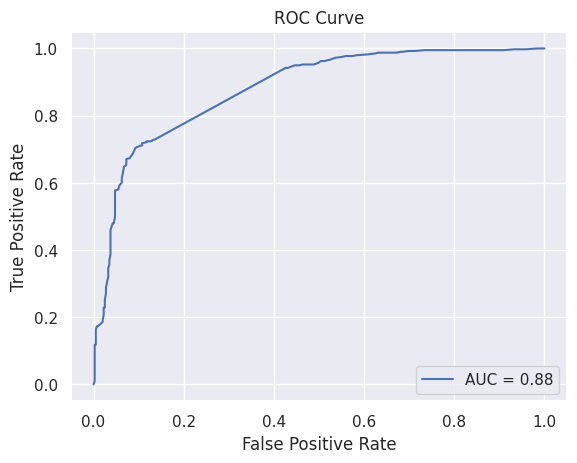

Accuracy: 0.8005018820577164
Precision: 0.8867313915857605
Recall: 0.6884422110552764
F1-score: 0.775106082036775
ROC AUC score: 0.8801683857885919


In [91]:
#FastText + Random Forest Classifier
print("\nFastText + Random Forest Classifier:")
avg_accuracy_fasttext_rf, avg_precision_fasttext_rf, avg_recall_fasttext_rf, avg_f1_fasttext_rf, avg_roc_auc_fasttext_rf = evaluate_rf(X_ft_train, X_ft_test, y_ft_train, y_ft_test)
print("Accuracy:", avg_accuracy_fasttext_rf)
print("Precision:", avg_precision_fasttext_rf)
print("Recall:", avg_recall_fasttext_rf)
print("F1-score:", avg_f1_fasttext_rf)
print("ROC AUC score:", avg_roc_auc_fasttext_rf)

# Export model

In [93]:
# Use the model with best accuracy : TF-IDF + SVM Classifier
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
svm_classifier.fit(X_tfidf_train, y_tfidf_train)
joblib.dump(svm_classifier, 'model.joblib')